In [179]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime, timedelta
import requests

In [57]:
countries = ['AT', 'BE', 'CZ', 'DE', 'LU', 'FR', 'HR', 'HU', 'NL', 'PL', 'RO', 'SI', 'SK']
zones = ['AT', 'BE', 'CZ', 'DE_LU', 'FR', 'HR', 'HU', 'NL', 'PL', 'RO', 'SI', 'SK']

borders = []

In [201]:
cne_selection_label = [r'$\alpha$10', r'$\alpha$5', 'n']

In [112]:
df_observed = pd.read_excel("./cost_curves/data/day_ahead_prices.xlsx", index_col=0)
start_date_feb = pd.Timestamp('20230201')
end_date_feb = pd.Timestamp('20230301')
df_observed = df_observed.loc[(df_observed.index > start_date_feb) & (df_observed.index <= end_date_feb)]

df_forecasts = []
df_forecasts.append(pd.read_excel("./cost_curves/price_forecasts/price_forecast_full_nuts_norm_1_w_atc_february.xlsx"))
df_forecasts.append(pd.read_excel("./cost_curves/price_forecasts/p
                                  rice_forecast_full_alpha5_norm_1_w_atc_february.xlsx"))
df_forecasts.append(pd.read_excel("./cost_curves/price_forecasts/volue_day_ahead_ec00.xlsx", index_col=0))

for index, df in enumerate(df_forecasts):
    df_forecasts[index].index = df_observed.index
    
df_errors_a10 = df_forecasts[0][zones].copy()
df_errors_a10 = df_errors_a10 - df_observed[zones]

df_errors_a5 = df_forecasts[1][zones].copy()
df_errors_a5 = df_errors_a5 - df_observed[zones]

df_errors_vol = df_forecasts[2][zones].copy()
df_errors_vol = df_errors_vol - df_observed[zones]

In [2]:
gdf_rg = gpd.read_file('./NUTS_RG_20M_2021_3035.geojson')
gdf_bn = gpd.read_file('./NUTS_BN_20M_2021_3035.geojson')
gdf_lb = gpd.read_file('./NUTS_LB_2021_3035.geojson')

In [113]:
non_eu_nuts = ['FR', 'FRY', 'FRY10', 'FRY20', 'FRY30', 'FRY40', 'FRY50', 'FRM0']
gdf_core = gdf_rg[(gdf_rg.CNTR_CODE.isin(countries)) & (~gdf_rg.NUTS_ID.isin(non_eu_nuts)) & (gdf_rg.LEVL_CODE.isin([1]))]

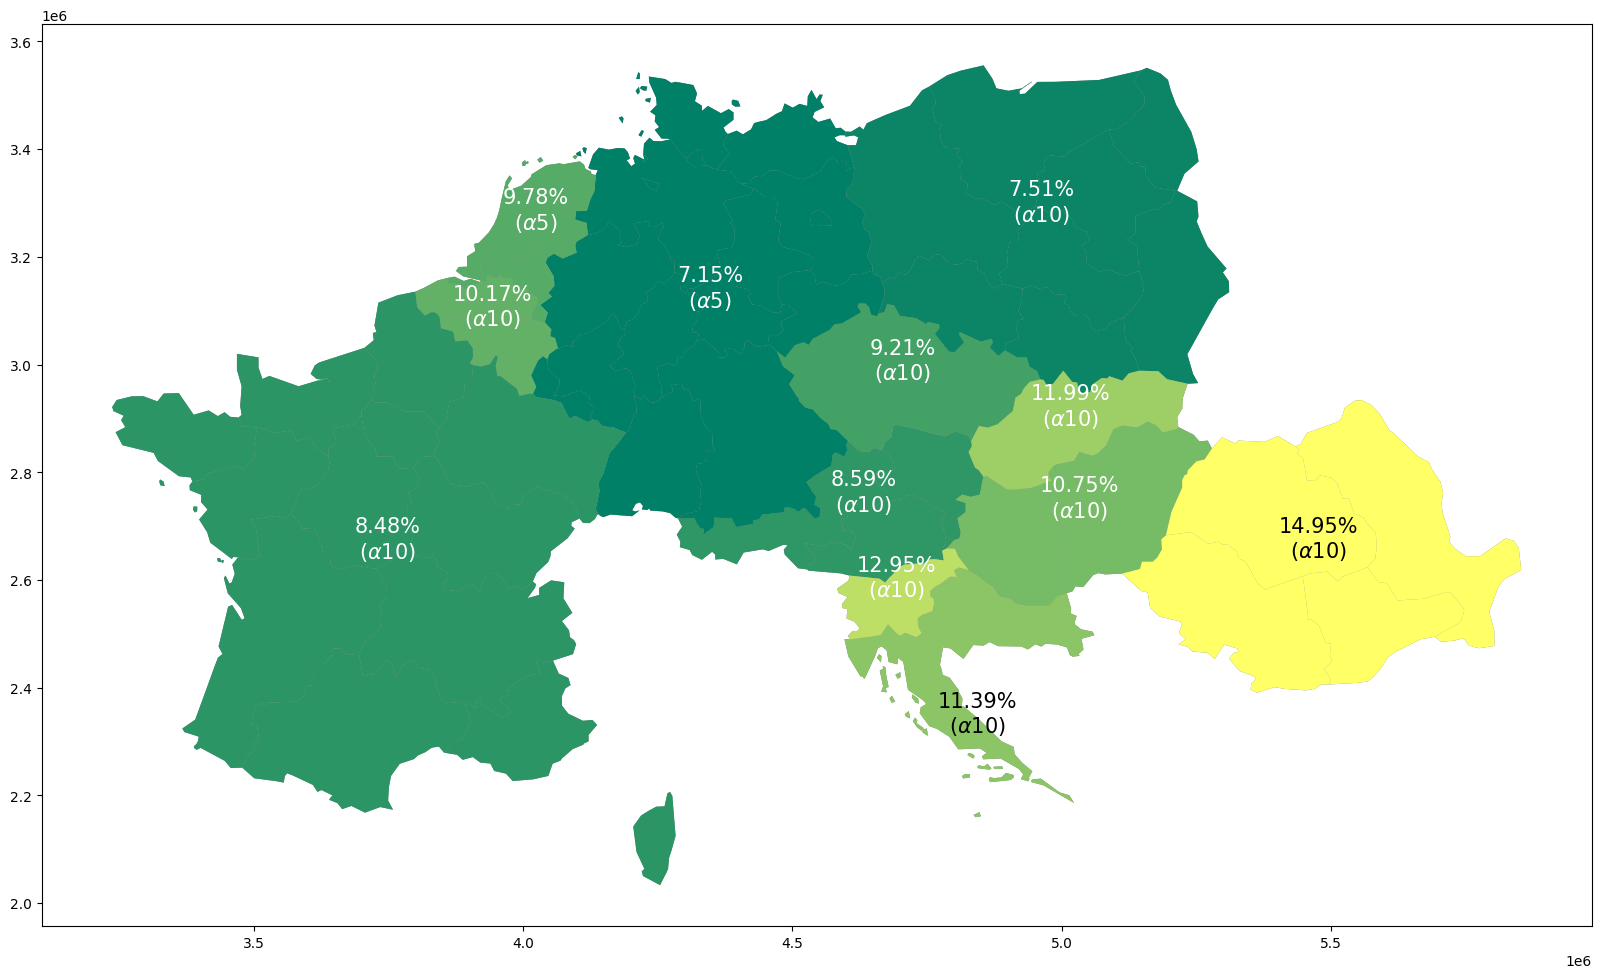

In [287]:
# PRICES
ax = gdf_core.plot(figsize=(20,15), color="gray")
cmap = matplotlib.colormaps['summer']

price_error_zones = []
price_error_zones_cne_selection = []
for index, zone in enumerate(zones):
    price_error_zones.append(min(
        100*df_errors_a10[zone].abs().mean()/df_observed[zones].stack().abs().mean(),
        100*df_errors_a5[zone].abs().mean()/df_observed[zones].stack().abs().mean(),
    ))
    
    price_error_zones_cne_selection.append(np.argmin([
        100*df_errors_a10[zone].abs().mean()/df_observed[zones].stack().abs().mean(),
        100*df_errors_a5[zone].abs().mean()/df_observed[zones].stack().abs().mean(),
    ]))
    
norm = matplotlib.colors.Normalize(vmin=min(price_error_zones), vmax=max(price_error_zones))
    
for index, zone in enumerate(zones):
    if zone == 'DE_LU':
        zone_cond = gdf_core.CNTR_CODE.isin(['DE', 'LU'])
    else:
        zone_cond = gdf_core.CNTR_CODE == zone
        
    gdf_core[zone_cond].plot(figsize=(20,15), ax=ax, color=cmap(norm(price_error_zones[index])))
    
for index, zone in enumerate(zones):
    if zone == 'DE_LU':
        zone_cond = gdf_lb.CNTR_CODE.isin(['DE', 'LU'])
    else:
        zone_cond = gdf_lb.CNTR_CODE == zone
        
    coords = gdf_lb[(zone_cond) & (gdf_lb.LEVL_CODE == 0)].geometry.apply(lambda x: x.representative_point().coords[:]).iloc[0][0]
    
    text_color = 'white'
    if zone in ['RO', 'HR']:
        text_color = 'black'
    plt.annotate("{1}%\n({0})".format(cne_selection_label[price_error_zones_cne_selection[index]], round(price_error_zones[index], 2)), xy=coords, 
                 horizontalalignment='center', 
                 color=text_color,
                 fontsize=15
    )

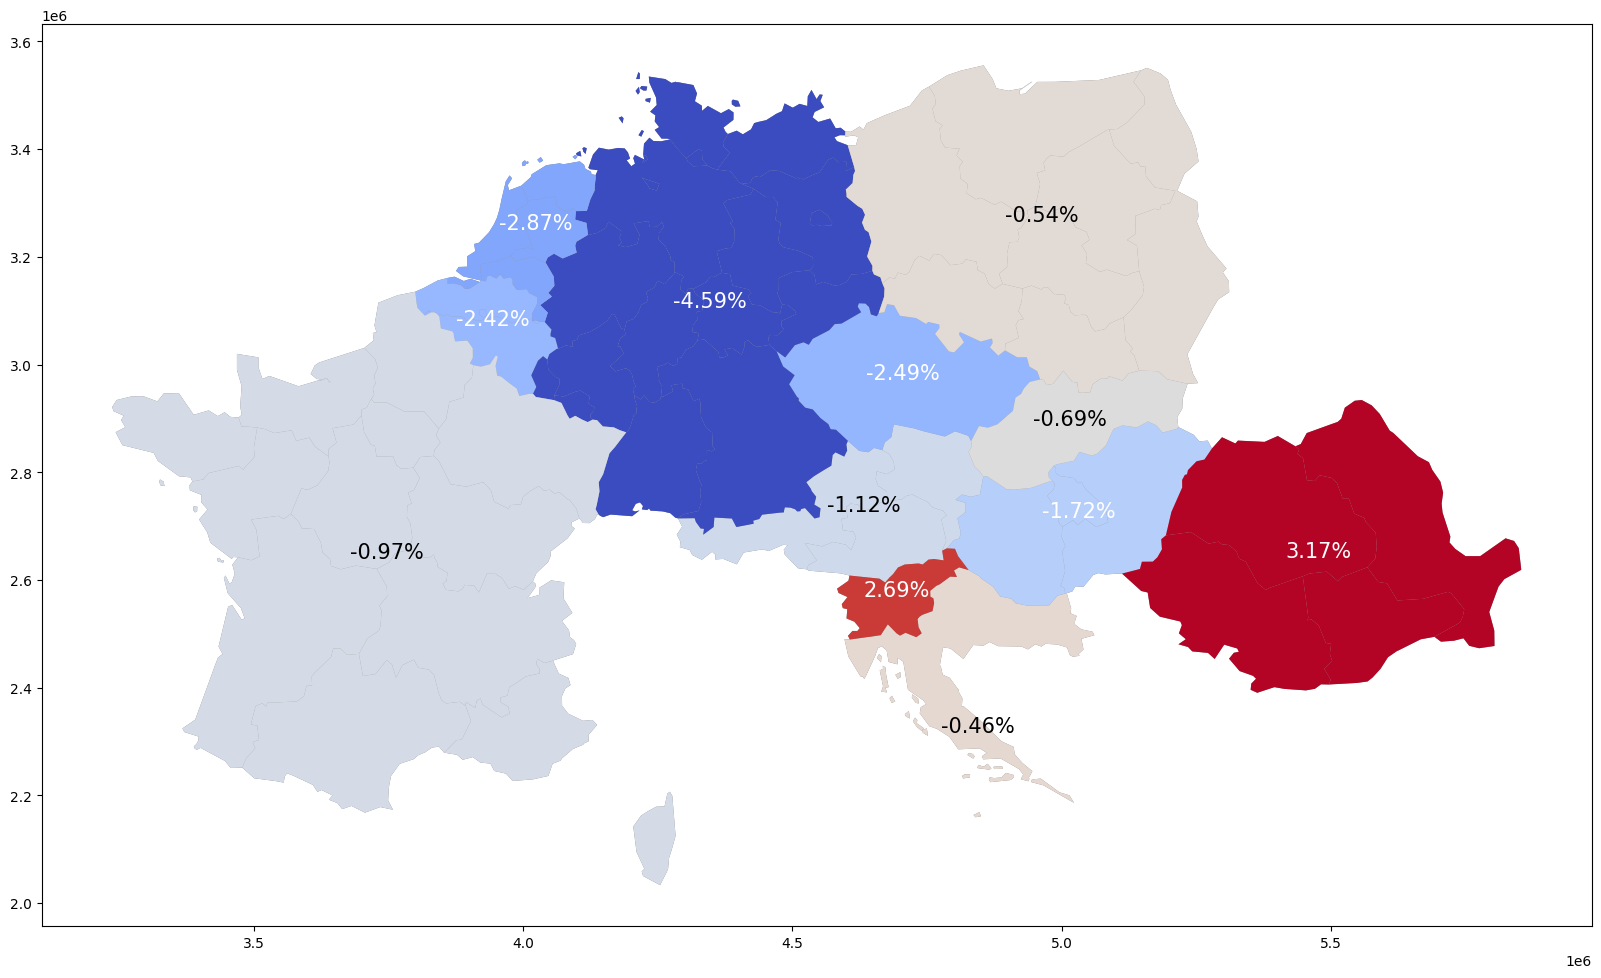

In [281]:
ax = gdf_core.plot(figsize=(20,15), color="gray")
cmap = matplotlib.colormaps['coolwarm']
price_error_zones_comm = []
for index, zone in enumerate(zones):
    price_error_zones_comm.append(
        price_error_zones[index] - 100*df_errors_vol[zone].abs().mean()/df_observed[zones].stack().abs().mean()
    )
    
norm = matplotlib.colors.Normalize(vmin=min(price_error_zones_comm), vmax=max(price_error_zones_comm))
    
for index, zone in enumerate(zones):
    if zone == 'DE_LU':
        zone_cond = gdf_core.CNTR_CODE.isin(['DE', 'LU'])
    else:
        zone_cond = gdf_core.CNTR_CODE == zone
        
    gdf_core[zone_cond].plot(figsize=(20,15), ax=ax, color=cmap(norm(price_error_zones_comm[index])))
    
for index, zone in enumerate(zones):
    if zone == 'DE_LU':
        zone_cond = gdf_lb.CNTR_CODE.isin(['DE', 'LU'])
    else:
        zone_cond = gdf_lb.CNTR_CODE == zone
        
    coords = gdf_lb[(zone_cond) & (gdf_lb.LEVL_CODE == 0)].geometry.apply(lambda x: x.representative_point().coords[:]).iloc[0][0]
    
    text_color = 'white'
    if zone in ['FR', 'HR', 'PL', 'SK', 'AT']:
        text_color = 'black'
    plt.annotate("{0}%".format(round(price_error_zones_comm[index], 2)), xy=coords, 
                 horizontalalignment='center', 
                 color=text_color,
                 fontsize=15
    )

In [121]:
# BORDER SELECTION
gpd.overlay(gdf_rg[(gdf_rg.id == 'NL') & (gdf_rg.LEVL_CODE == 0)], gdf_rg[(gdf_rg.id == 'DE') & (gdf_rg.LEVL_CODE == 0)], how='intersection', keep_geom_type=False).plot(color="green", ax=ax)
gpd.overlay(gdf_rg[(gdf_rg.id == 'NL') & (gdf_rg.LEVL_CODE == 0)], gdf_rg[(gdf_rg.id == 'BE') & (gdf_rg.LEVL_CODE == 0)], how='intersection', keep_geom_type=False).plot(color="red", ax=ax)

<Axes: >

<Figure size 640x480 with 0 Axes>

In [131]:
df_grid = pd.read_excel('./flow_based_domain/grid.xlsx', index_col=0)

In [124]:
df_ptdf_obs = pd.read_excel('./flow_based_domain/ptdf_z_obs.xlsx', index_col=0)

In [125]:
df_ptdf_forecasts = []
print('alpha 10')
df_ptdf_forecasts.append(pd.read_excel('./flow_based_domain/ptdf_z_calc_nuts.xlsx', index_col=0))
print('alpha 5')
df_ptdf_forecasts.append(pd.read_excel('./flow_based_domain/ptdf_z_calc_nuts_feb_5.xlsx', index_col=0))
print('naive')
df_ptdf_forecasts.append(pd.read_excel('./flow_based_domain/ptdf_z_naive.xlsx', index_col=0))

alpha 10
alpha 5
naive


In [127]:
df_np_observed = pd.read_excel("./cost_curves/data/net_positions.xlsx", index_col=0)
df_np_observed = df_np_observed.loc[(df_np_observed.index > start_date_feb) & (df_np_observed.index <= end_date_feb)]

In [247]:
f_init = np.zeros(len(df_np_observed.index))

border_flows_obs = {
    'AT-CZ': f_init.copy(), 'AT-DE': f_init.copy(), 'AT-HU': f_init.copy(), 'AT-SI': f_init.copy(), 'BE-FR': f_init.copy(),
    'BE-NL': f_init.copy(), 'CZ-DE': f_init.copy(), 'CZ-PL': f_init.copy(), 'CZ-SK': f_init.copy(), 'DE-FR': f_init.copy(),
    'DE-NL': f_init.copy(), 'HR-HU': f_init.copy(), 'HR-SI': f_init.copy(), 'HU-SK': f_init.copy(), 'HU-RO': f_init.copy(),
    'BE-DE': f_init.copy(), 'DE-PL': f_init.copy(), 'HU-SI': f_init.copy(), 'PL-SK': f_init.copy(), 'AT-SK': f_init.copy()
}

for t, timestamp in enumerate(df_np_observed.index):
    cnes = df_ptdf_obs[df_ptdf_obs.DateTime == timestamp]
    for cne_i, cne in cnes.iterrows():
        eic = df_grid.loc[cne['line_id'], 'eic']
        if df_grid.loc[cne['line_id'], 'tieline'] and eic[:4] == '10T-':
            z1 = eic[4:6]
            z2 = eic[7:9]
            flow = 0
            for zone in zones:
                flow += cne[zone] * df_np_observed.loc[timestamp, zone]
            
            border_flows_obs[z1 + '-' + z2][t] += -1*flow

In [248]:
border_flow_forecasts = []

df_np_forecasts = []
df_np_forecasts.append(pd.read_excel("./cost_curves/np_forecasts/np_forecast_full_nuts_norm_1_w_atc_february.xlsx"))
df_np_forecasts.append(pd.read_excel("./cost_curves/np_forecasts/np_forecast_full_alpha5_norm_1_w_atc_february.xlsx"))
df_np_forecasts.append(pd.read_excel("./cost_curves/np_forecasts/np_forecast_full_naive_norm_1_w_atc_february.xlsx"))

for index, df in enumerate(df_np_forecasts):
    df_np_forecasts[index].index = df_np_observed.index

    border_flows_calc = {
        'AT-CZ': f_init.copy(), 'AT-DE': f_init.copy(), 'AT-HU': f_init.copy(), 'AT-SI': f_init.copy(), 'BE-FR': f_init.copy(),
        'BE-NL': f_init.copy(), 'CZ-DE': f_init.copy(), 'CZ-PL': f_init.copy(), 'CZ-SK': f_init.copy(), 'DE-FR': f_init.copy(),
        'DE-NL': f_init.copy(), 'HR-HU': f_init.copy(), 'HR-SI': f_init.copy(), 'HU-SK': f_init.copy(), 'HU-RO': f_init.copy(),
        'BE-DE': f_init.copy(), 'DE-PL': f_init.copy(), 'HU-SI': f_init.copy(), 'PL-SK': f_init.copy(), 'AT-SK': f_init.copy()
    }

    for t, timestamp in enumerate(df_np_observed.index):
        if 'DateTime' in df_ptdf_forecasts[index].columns:
            cnes = df_ptdf_forecasts[index][df_ptdf_forecasts[index].DateTime == timestamp]
        else:
            cnes = df_ptdf_forecasts[index][df_ptdf_forecasts[index].index == timestamp]
        for cne_i, cne in cnes.iterrows():
            eic = df_grid.loc[cne['line_id'], 'eic']
            if df_grid.loc[cne['line_id'], 'tieline'] and eic[:4] == '10T-':
                z1 = eic[4:6]
                z2 = eic[7:9]
                flow = 0
                for zone in zones:
                    flow += cne[zone] * df_np_forecasts[index].loc[timestamp, zone]

                border_flows_calc[z1 + '-' + z2][t] += -1*flow
        
    border_flow_forecasts.append(border_flows_calc)

In [188]:
def retrieve_maxbex(fromDate, toDate):
    data = {
        'fromUtc': f'{fromDate}T00:00:00.000Z',
        'toUtc': f'{toDate}T23:00:00.000Z',
    }

    try:
        response = requests.post('https://publicationtool.jao.eu/core/api/data/maxExchanges', json=data)
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
    return pd.DataFrame(response.json()['data'])

start = datetime(2023, 2, 1).strftime('%Y-%m-%d')
end = datetime(2023, 3, 1).strftime('%Y-%m-%d')

df_maxbex = retrieve_maxbex(start, end)
df_maxbex = df_maxbex[0:672]
df_maxbex.index = df_np_observed.index

In [192]:
border_flows_maxbex = {
    'AT-CZ': f_init.copy(), 'AT-DE': f_init.copy(), 'AT-HU': f_init.copy(), 'AT-SI': f_init.copy(), 'BE-FR': f_init.copy(),
    'BE-NL': f_init.copy(), 'CZ-DE': f_init.copy(), 'CZ-PL': f_init.copy(), 'CZ-SK': f_init.copy(), 'DE-FR': f_init.copy(),
    'DE-NL': f_init.copy(), 'HR-HU': f_init.copy(), 'HR-SI': f_init.copy(), 'HU-SK': f_init.copy(), 'HU-RO': f_init.copy(),
    'BE-DE': f_init.copy(), 'DE-PL': f_init.copy(), 'HU-SI': f_init.copy(), 'PL-SK': f_init.copy(), 'AT-SK': f_init.copy()
}

for t, (timestmap, maxbex_row) in enumerate(df_maxbex.iterrows()):
    for border in border_flows_maxbex.keys():
        z = border.split('-')
        border_flows_maxbex[border][t] = max(maxbex_row['border_' + z[0] + '_' + z[1]], maxbex_row['border_' + z[1] + '_' + z[0]])

AT-CZ


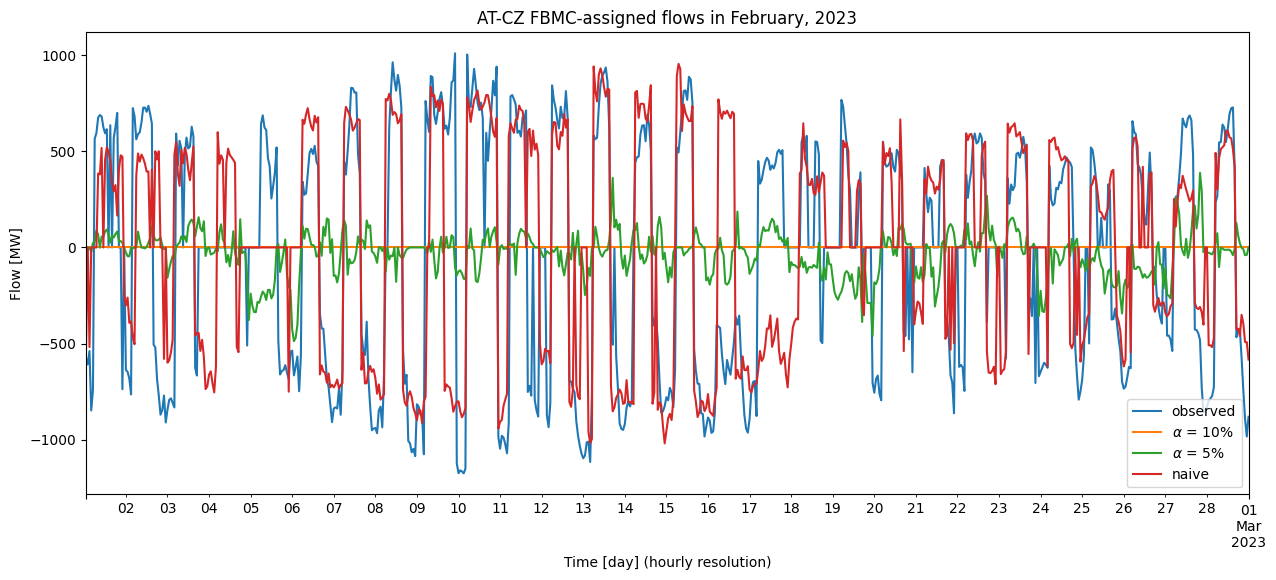

AT-DE


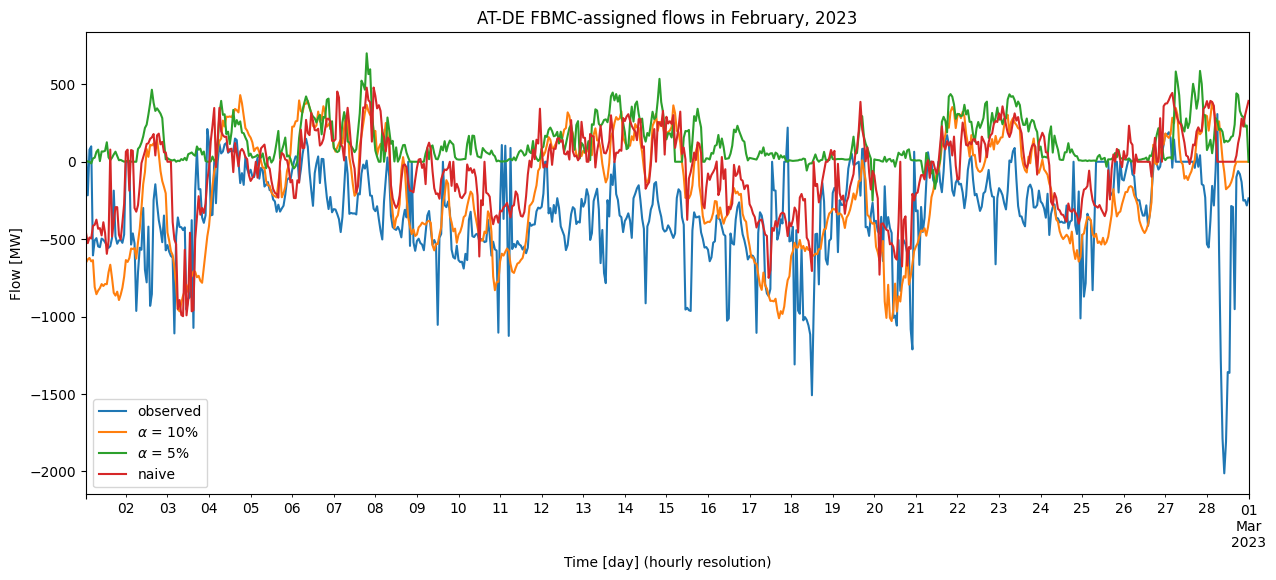

AT-HU


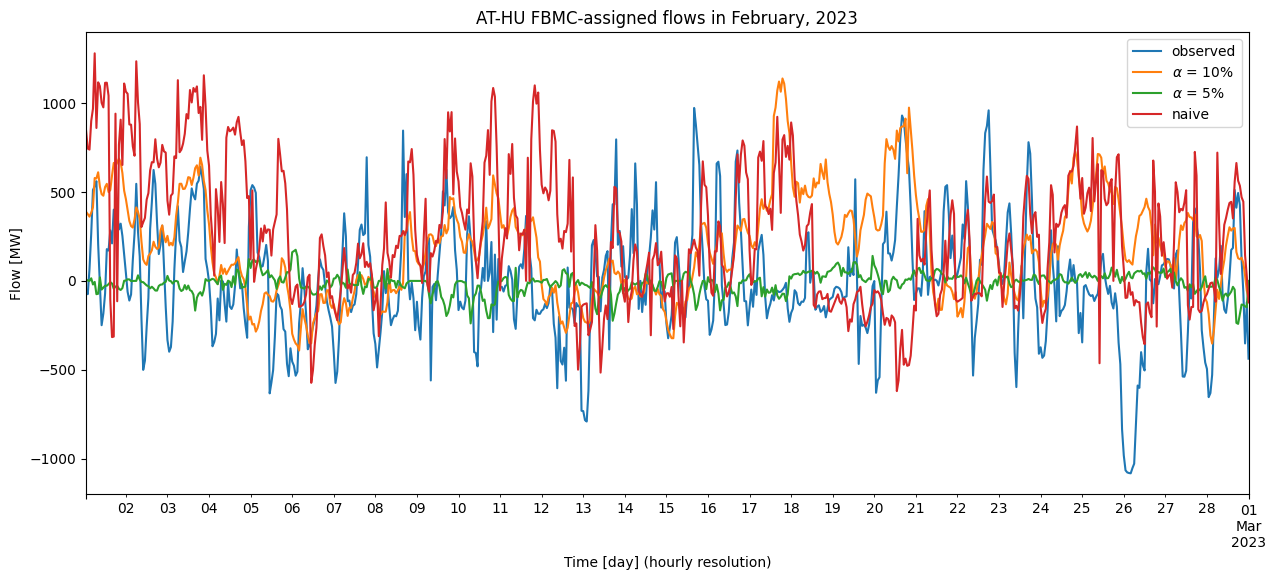

AT-SI


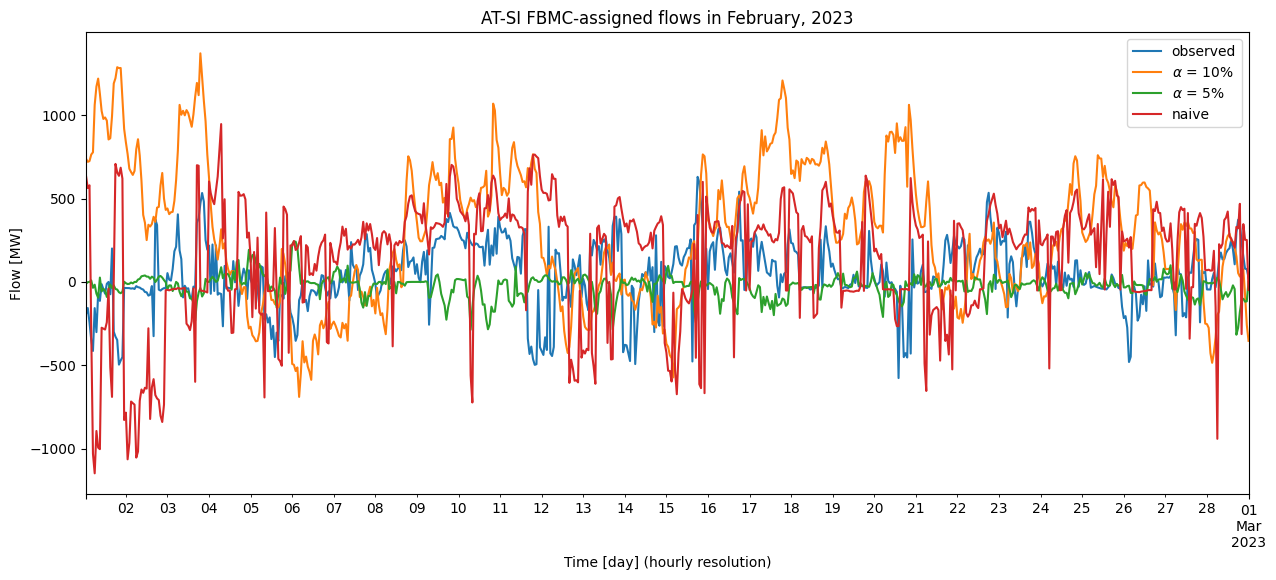

BE-FR


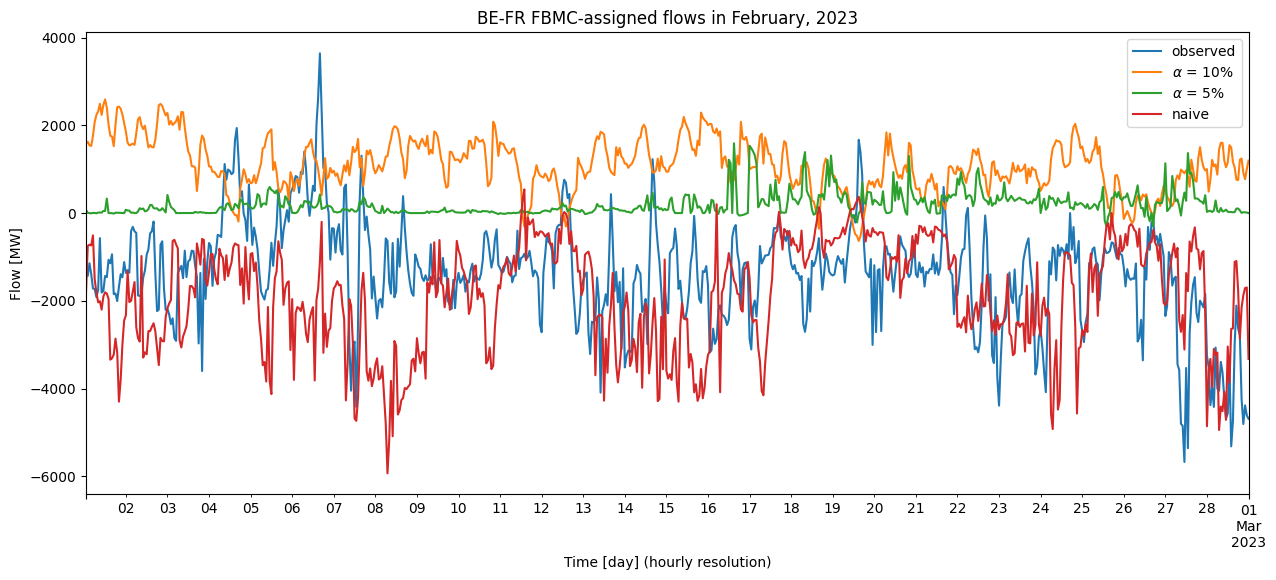

BE-NL


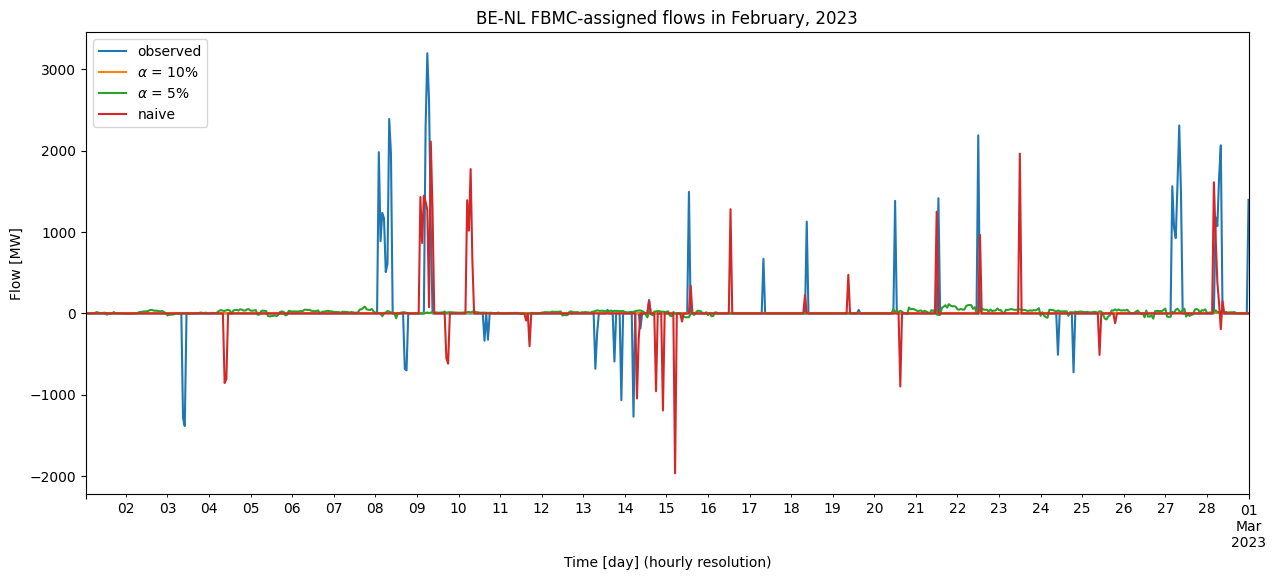

CZ-DE


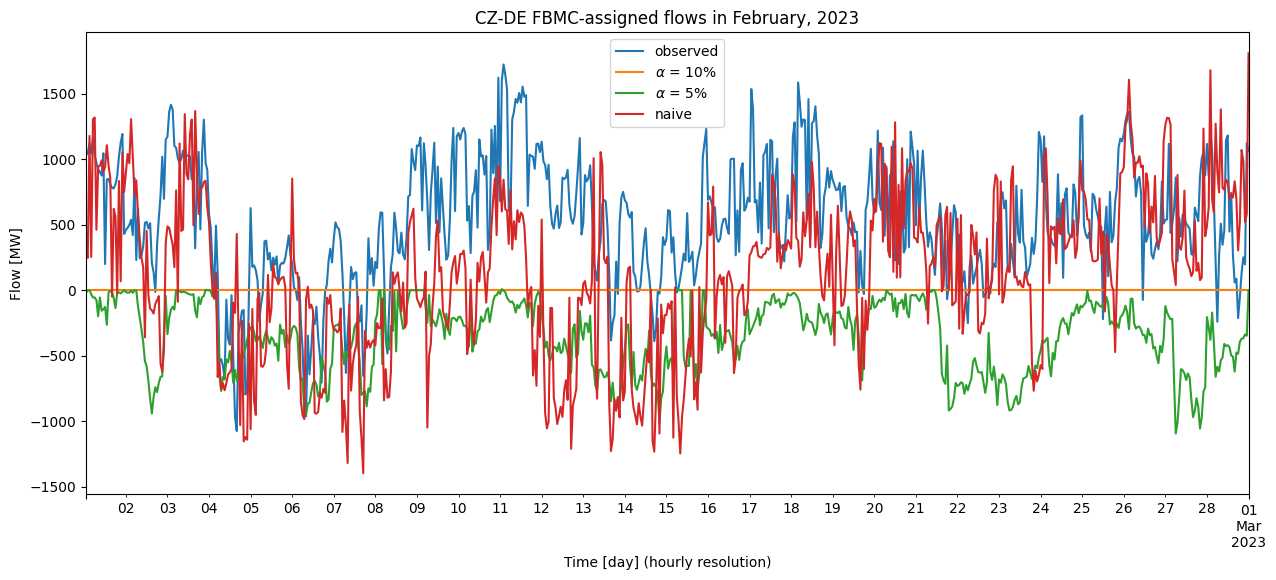

CZ-PL


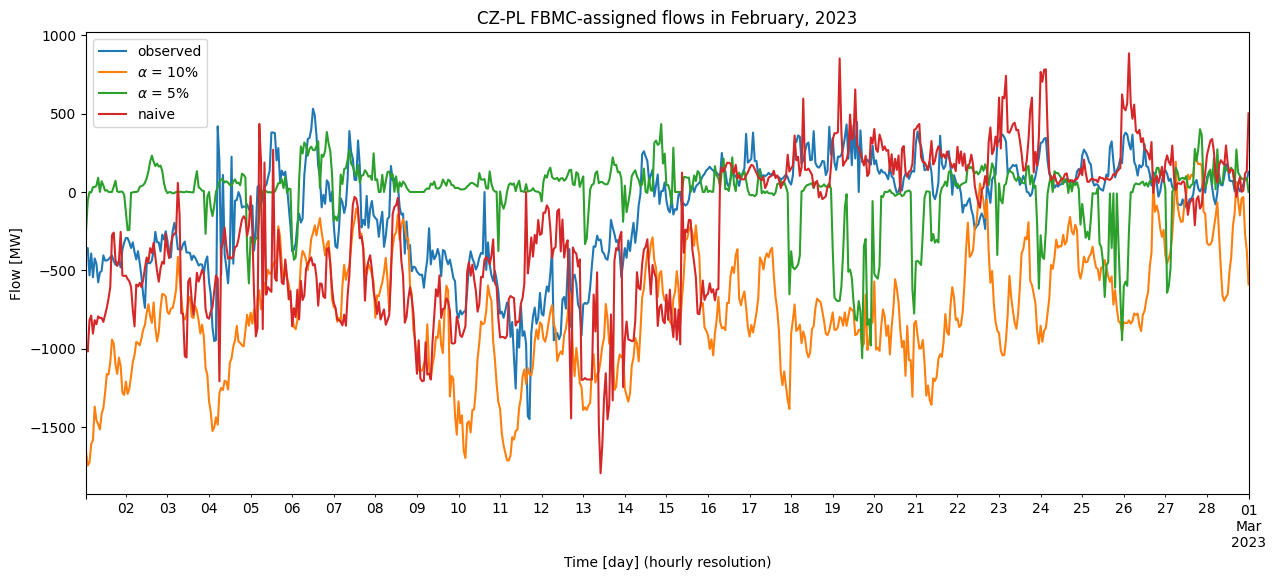

CZ-SK


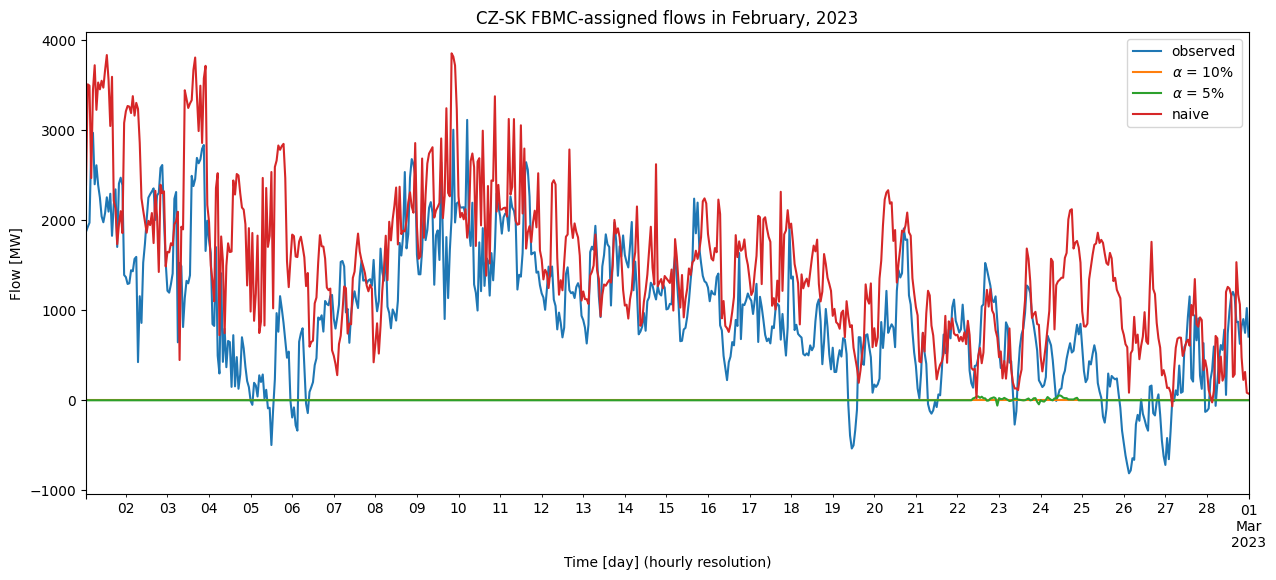

DE-FR


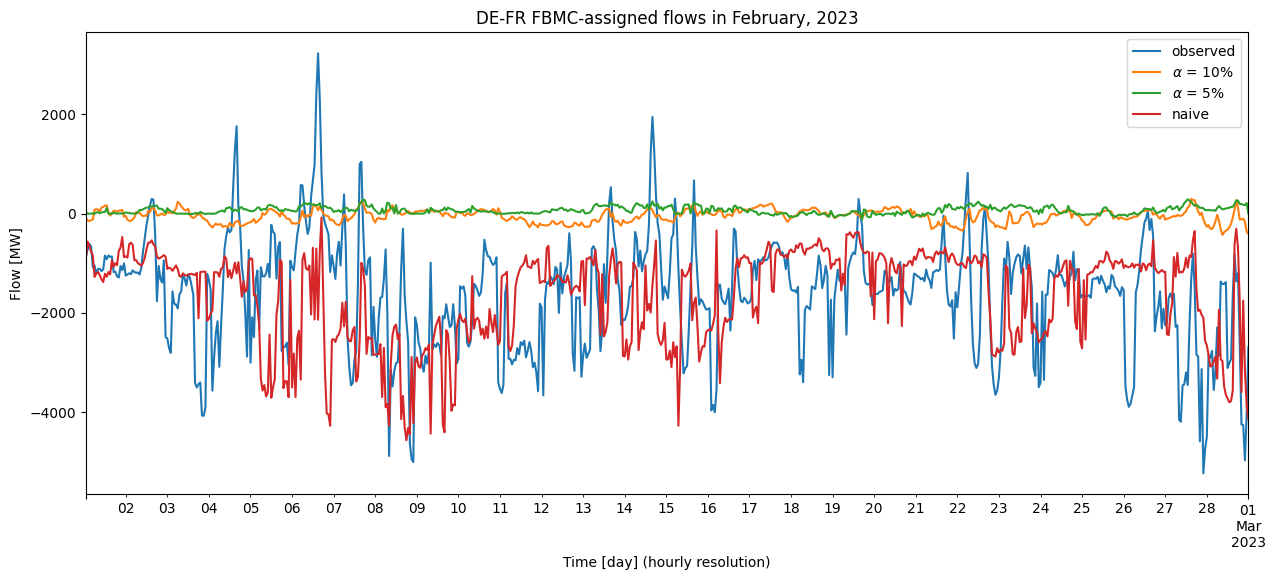

DE-NL


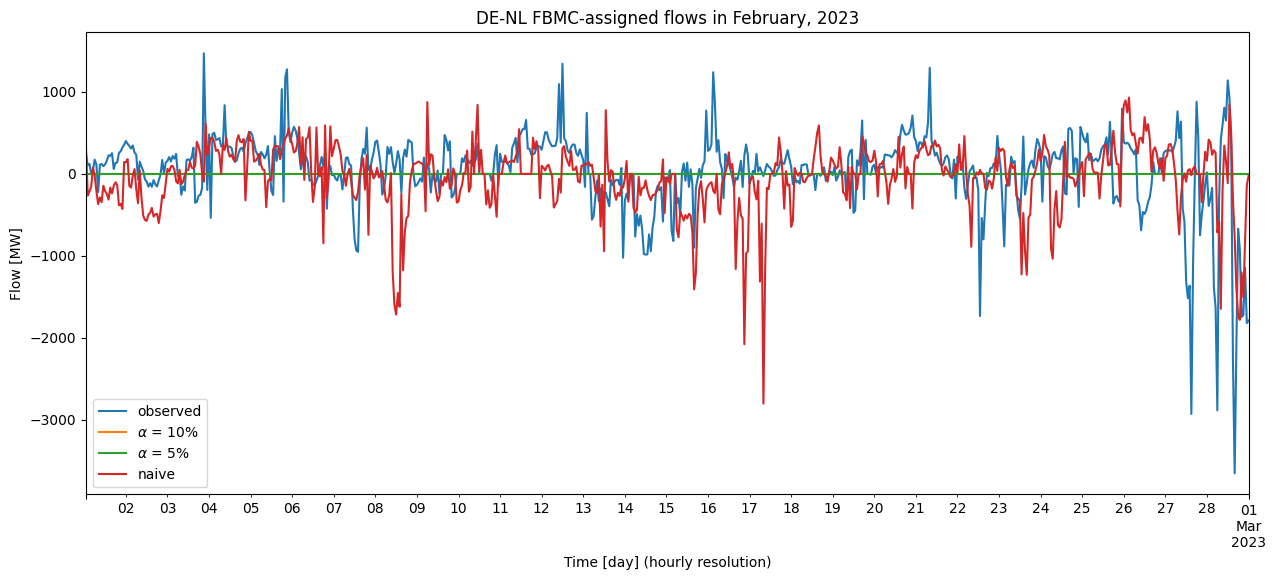

HR-HU


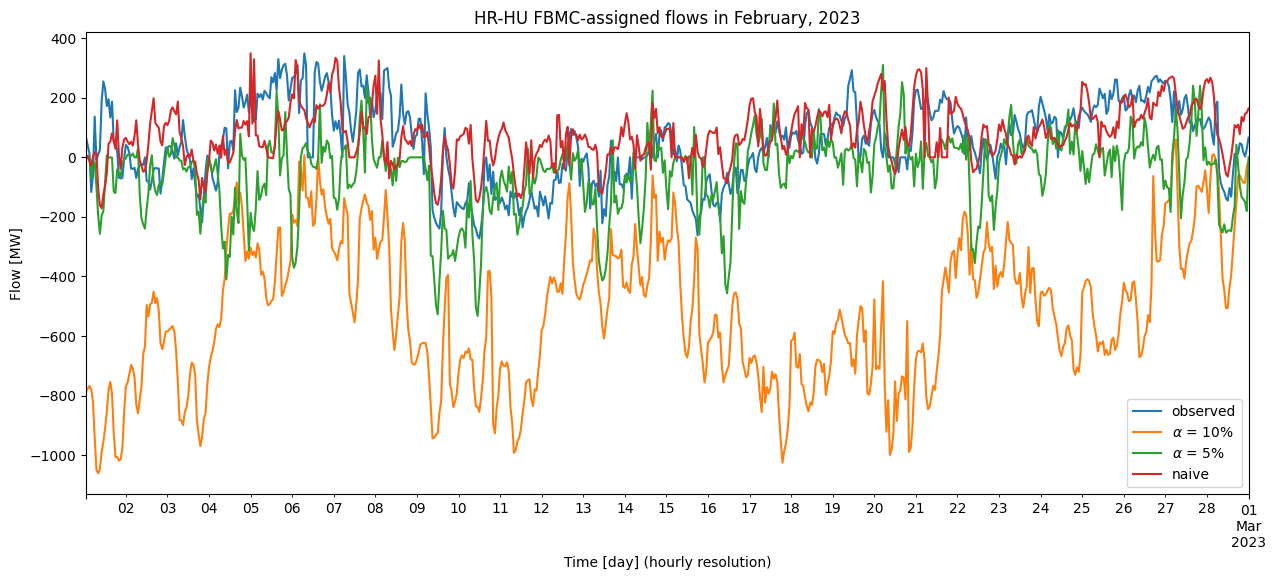

HR-SI


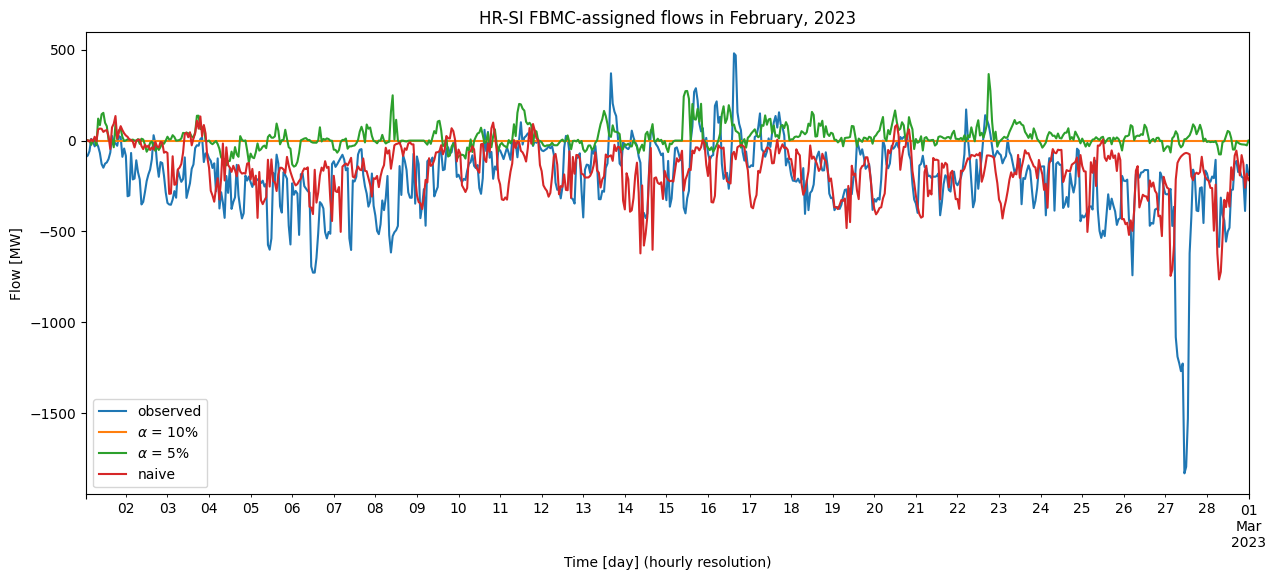

HU-SK


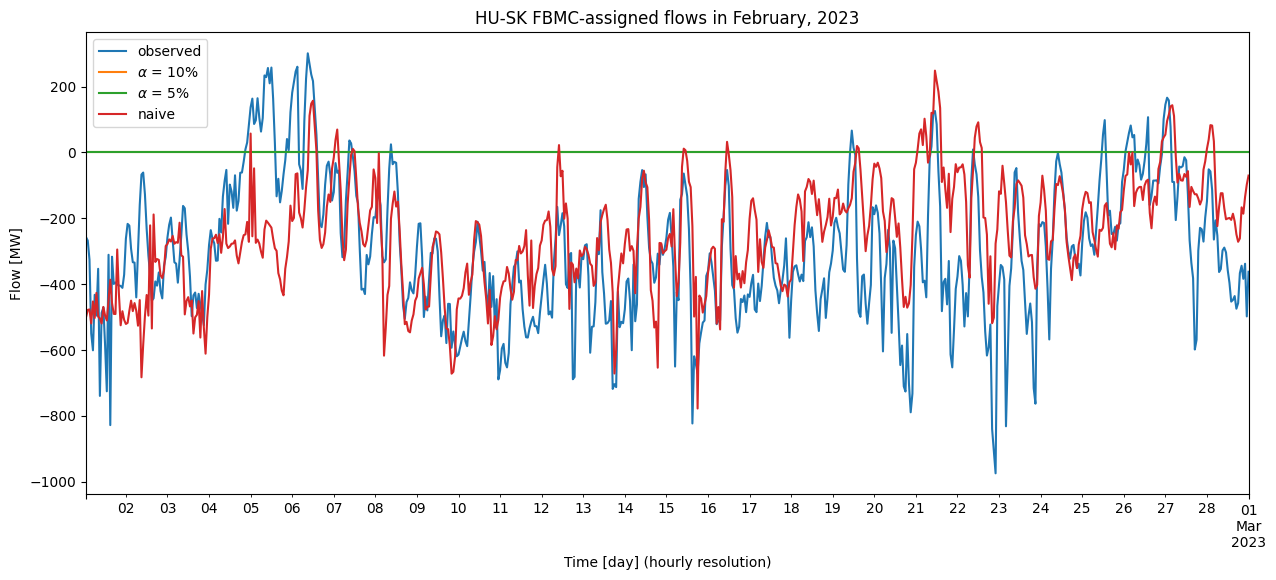

HU-RO


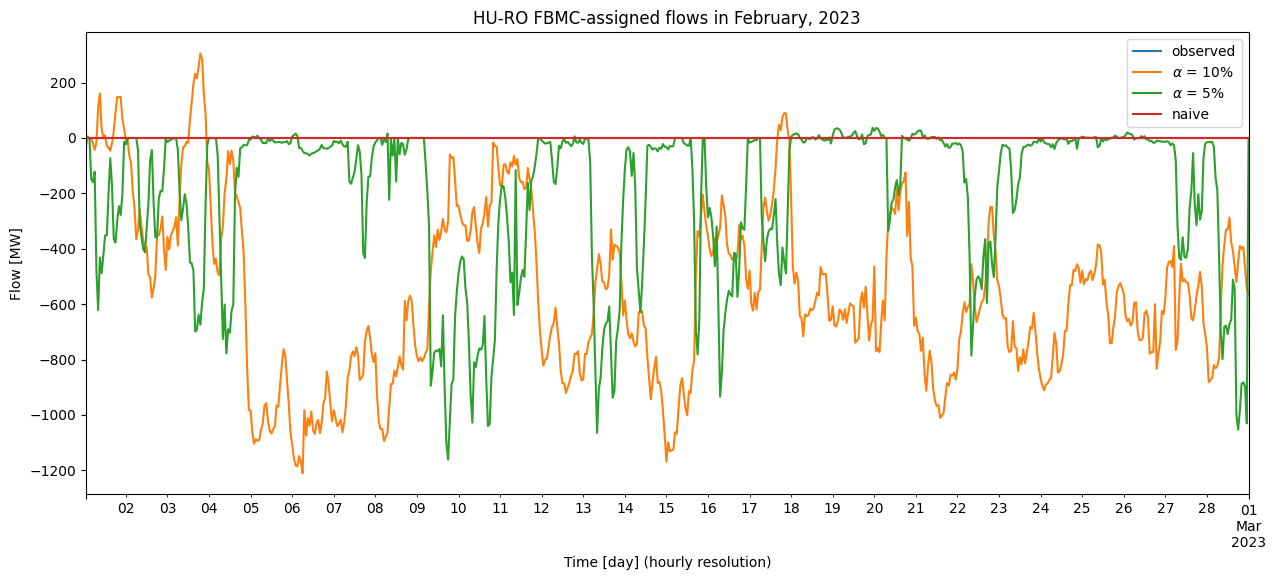

BE-DE


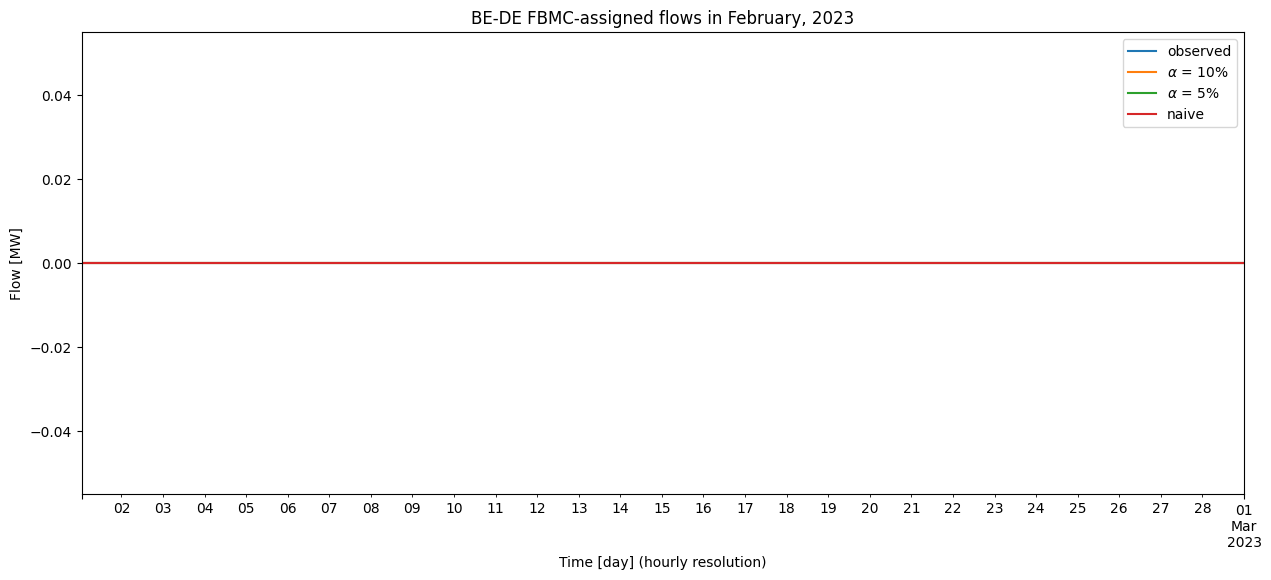

DE-PL


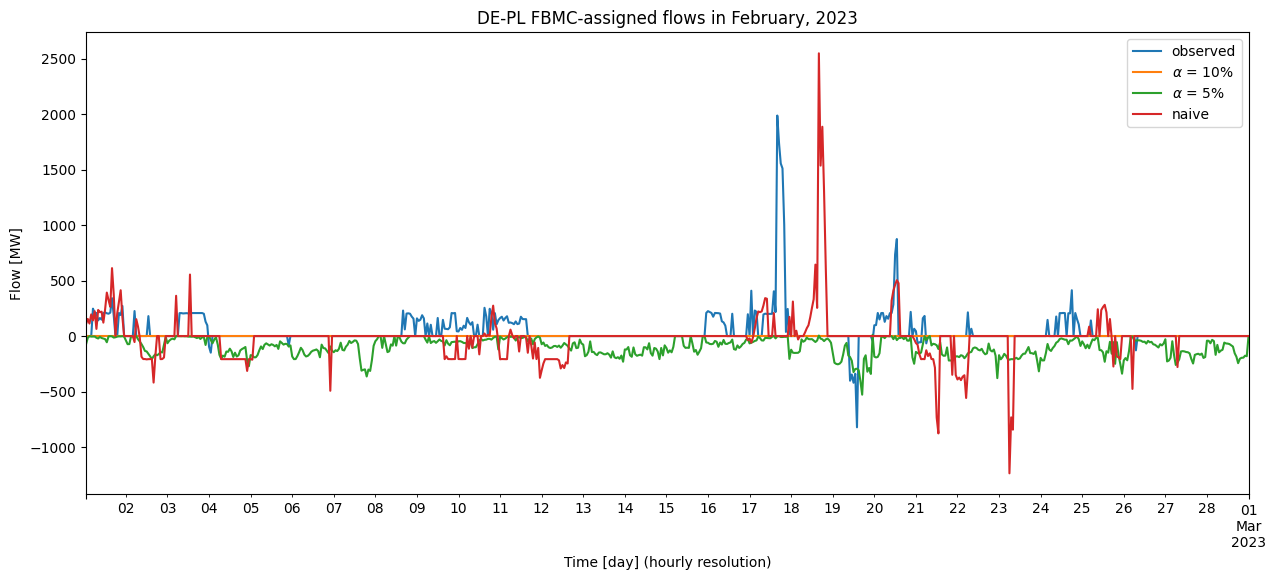

HU-SI


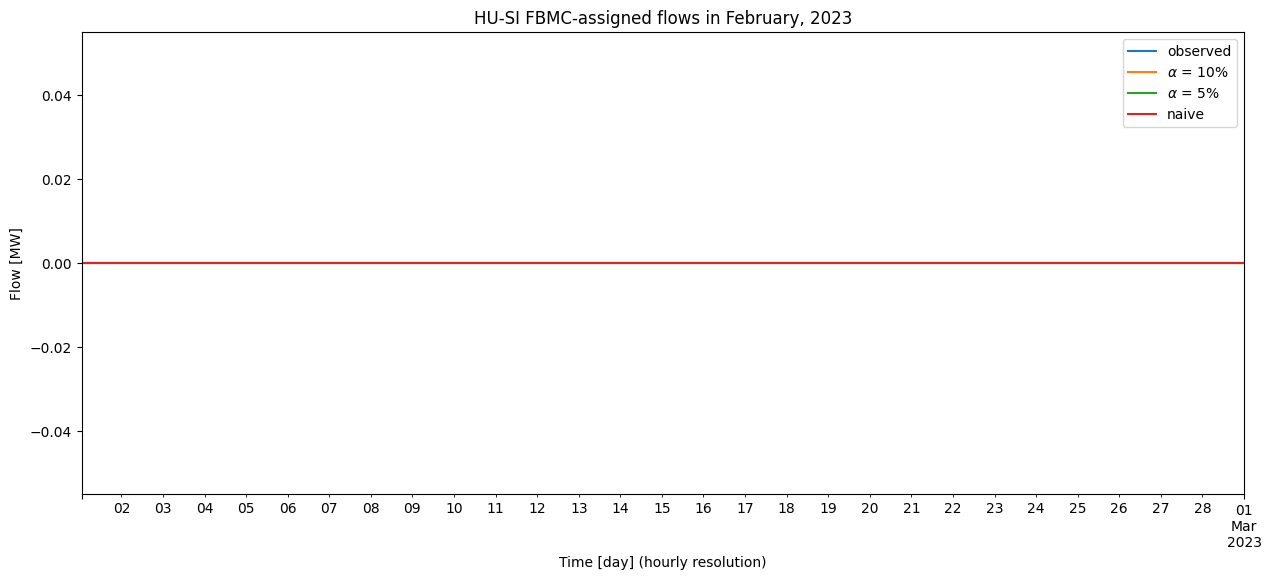

PL-SK


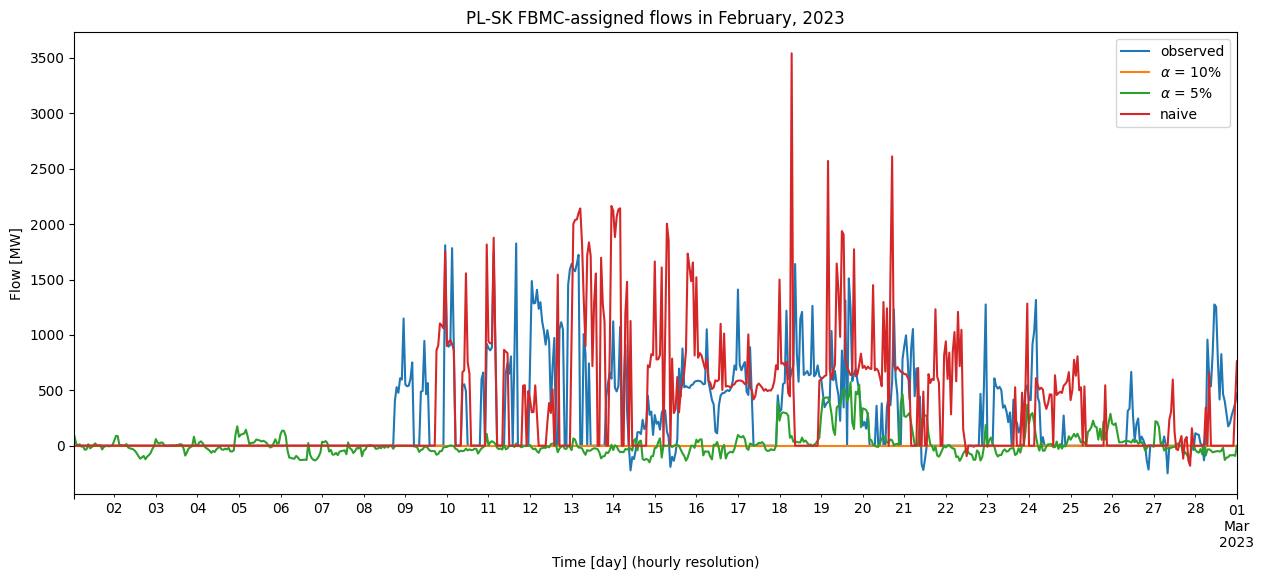

AT-SK


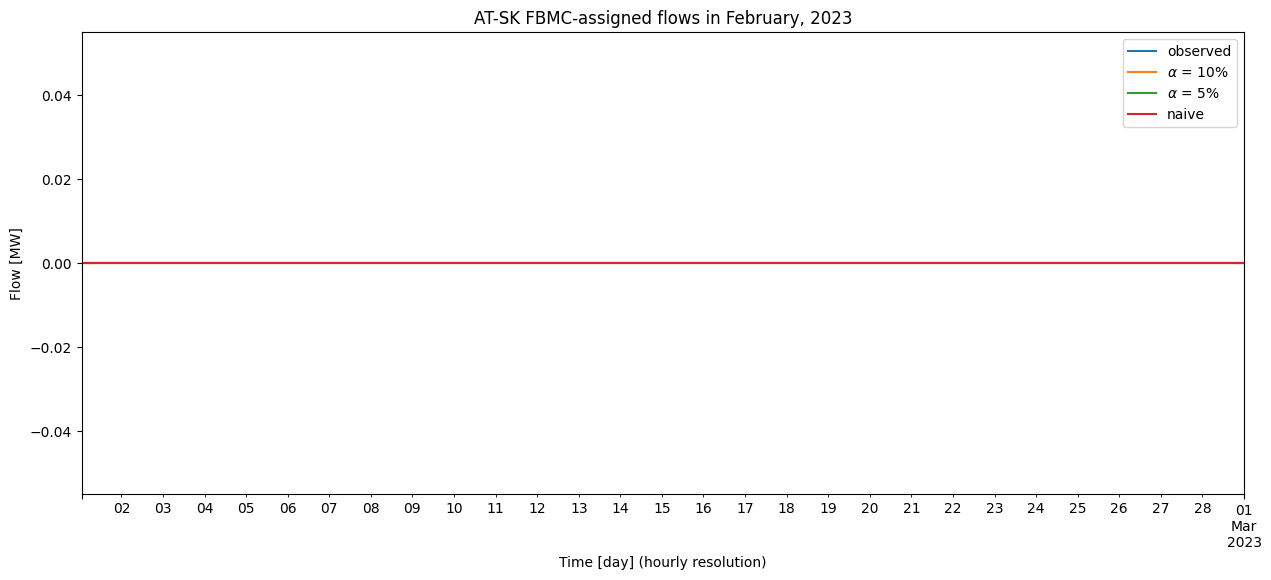

In [273]:
for border in border_flows_obs.keys():
    plt.figure(figsize=(15,6))
    
    print(border)
    df_flow_forecast = df_np_forecasts[0].copy()
    df_flow_forecast['flow_obs'] = border_flows_obs[border]
    ax = df_flow_forecast['flow_obs'].plot()
    
    for index, df in enumerate(df_np_forecasts):
        df_flow_forecast = df_np_forecasts[0].copy()
        df_flow_forecast['flow_calc'] = border_flow_forecasts[index][border]
        df_flow_forecast['flow_calc'].plot(ax=ax)
    
    plt.title("{0} FBMC-assigned flows in February, 2023".format(border))
    plt.ylabel('Flow [MW]')
    plt.xlabel('Time [day] (hourly resolution)')
    
    ax.legend([
        'observed', 
        r'$\alpha$ = 10%',
        r'$\alpha$ = 5%',
        'naive'
    ])
    
    plt.show()

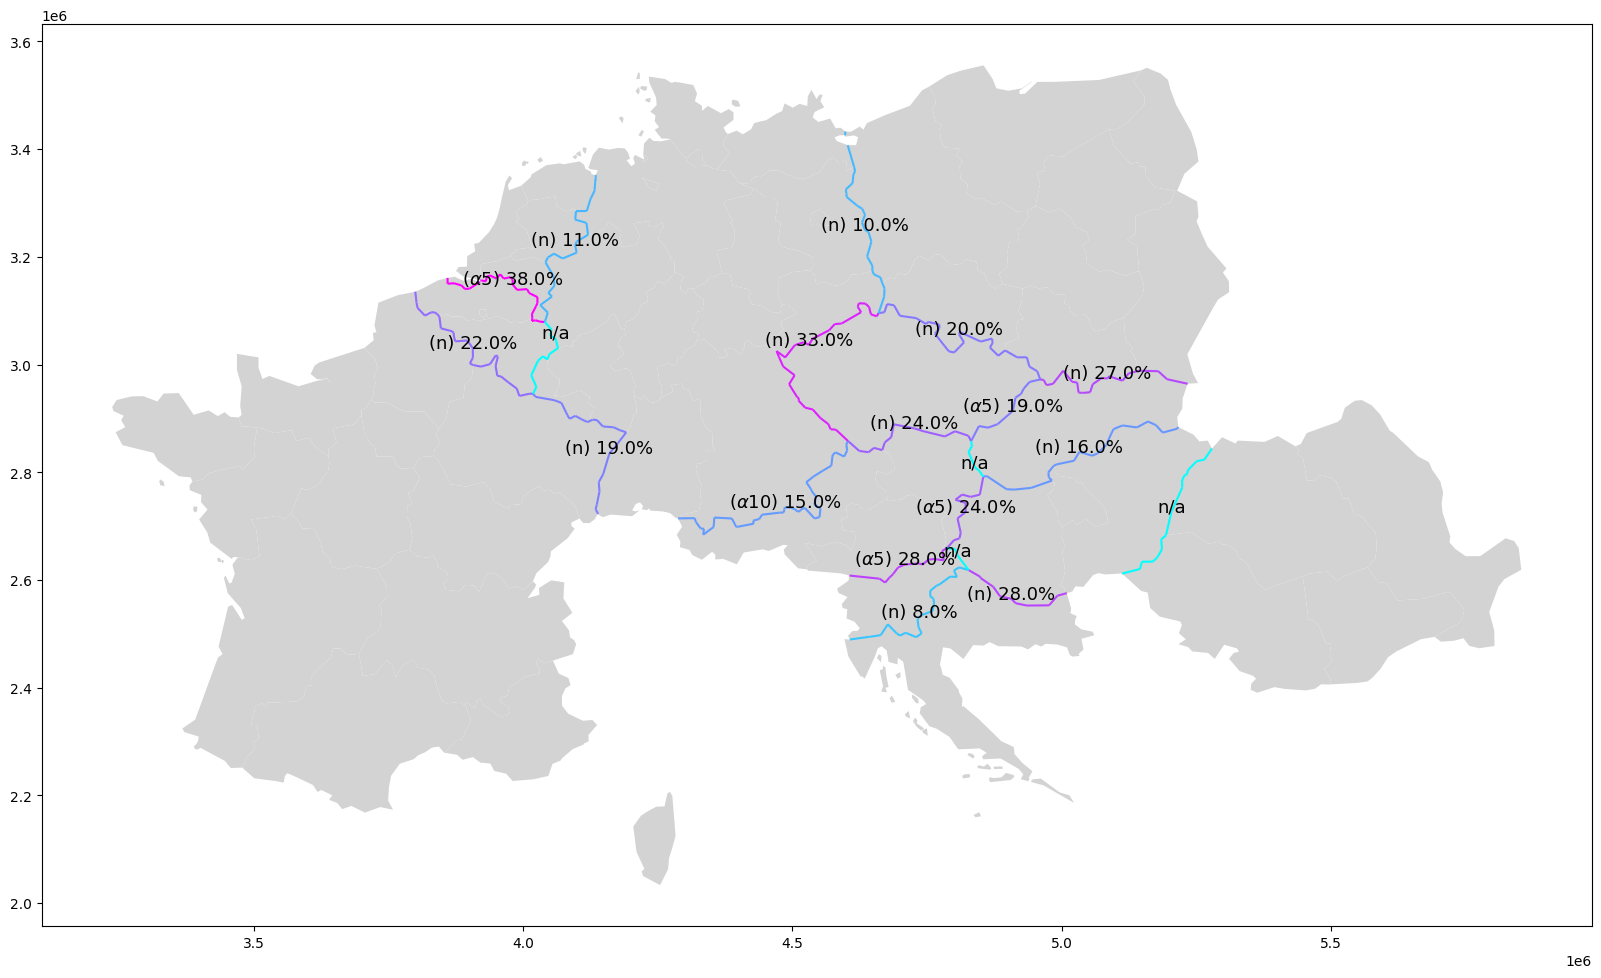

In [277]:
# FLOWS

def annotate_flow(index):
    if flow_error_zones[index] > 0:
        return "({0}) {1}%".format(cne_selection_label[flow_best_cne_selection[index]], round(flow_error_zones[index], 0))
    else:
        return "n/a"
    
ax = gdf_core.plot(figsize=(20,15), color="lightgray")
cmap = matplotlib.colormaps['cool']

flow_error_zones = []
flow_best_cne_selection = []
for border in border_flows_obs.keys():
    
    diff_a10 = []
    diff_a5 = []
    diff_n = []
    
    for t in range(len(border_flows_obs[border])):
        diff_a10_t = border_flows_obs[border][t] - border_flow_forecasts[0][border][t]
        diff_a5_t = border_flows_obs[border][t] - border_flow_forecasts[1][border][t]
        diff_n_t = border_flows_obs[border][t] - border_flow_forecasts[2][border][t]
        if abs(border_flows_obs[border][t]) > 0:
            if abs(border_flow_forecasts[0][border][t]) > 0:
                diff_a10.append(abs(diff_a10_t))
            if abs(border_flow_forecasts[1][border][t]) > 0:
                diff_a5.append(abs(diff_a5_t))
            if abs(border_flow_forecasts[2][border][t]) > 0:
                diff_n.append(abs(diff_n_t))
            
    if len(diff_a10) > 0:
        mean_a10 = np.mean(diff_a10)
    else:
        mean_a10 = 0
        
    if len(diff_a5) > 0:
        mean_a5 = np.mean(diff_a5)
    else:
        mean_a5 = 0
        
    if len(diff_n) > 0:
        mean_n = np.mean(diff_n)
    else:
        mean_n = 0
        
        
    border_flows_denom = np.max(abs(border_flows_obs[border]))

    if border_flows_denom > 0:
        flow_error_zones.append(min(
            (100*mean_a10 / border_flows_denom) if mean_a10 > 0 else 10000,
            (100*mean_a5 / border_flows_denom) if mean_a5 > 0 else 10000,
            (100*mean_n / border_flows_denom) if mean_n > 0 else 10000,
        ))

        flow_best_cne_selection.append(np.argmin([
            (100*mean_a10 / border_flows_denom) if mean_a10 > 0 else 10000,
            (100*mean_a5 / border_flows_denom) if mean_a5 > 0 else 10000,
            (100*mean_n / border_flows_denom) if mean_n > 0 else 10000,
        ]))
    else:
        flow_error_zones.append(0)
        flow_best_cne_selection.append(0)
        
    
norm = matplotlib.colors.Normalize(vmin=min(flow_error_zones), vmax=max(flow_error_zones))
    
for index, border in enumerate(border_flows_obs.keys()):
    b = border.split('-')
    if border == 'DE-FR':
        gdf_border = gpd.overlay(gdf_rg[(gdf_rg.id == 'LU') & (gdf_rg.LEVL_CODE == 0)], gdf_rg[(gdf_rg.id == 'FR') & (gdf_rg.LEVL_CODE == 0)], how='intersection', keep_geom_type=False)
        gdf_border.plot(figsize=(20,15), ax=ax, color=cmap(norm(flow_error_zones[index])))
        
    if border == 'BE-DE':
        gdf_border = gpd.overlay(gdf_rg[(gdf_rg.id == 'LU') & (gdf_rg.LEVL_CODE == 0)], gdf_rg[(gdf_rg.id == 'BE') & (gdf_rg.LEVL_CODE == 0)], how='intersection', keep_geom_type=False)
        gdf_border.plot(figsize=(20,15), ax=ax, color=cmap(norm(flow_error_zones[index])))
        
    gdf_border = gpd.overlay(gdf_rg[(gdf_rg.id == b[0]) & (gdf_rg.LEVL_CODE == 0)], gdf_rg[(gdf_rg.id == b[1]) & (gdf_rg.LEVL_CODE == 0)], how='intersection', keep_geom_type=False)
    gdf_border.plot(figsize=(20,15), ax=ax, color=cmap(norm(flow_error_zones[index])))
    
for index, border in enumerate(border_flows_obs.keys()):
    b = border.split('-')
    gdf_border = gpd.overlay(gdf_rg[(gdf_rg.id == b[0]) & (gdf_rg.LEVL_CODE == 0)], gdf_rg[(gdf_rg.id == b[1]) & (gdf_rg.LEVL_CODE == 0)], how='intersection', keep_geom_type=False)
    coords = gdf_border.geometry.apply(lambda x: x.representative_point().coords[:]).iloc[0][0]
    
    plt.annotate(annotate_flow(index), xy=coords, 
                 horizontalalignment='center', 
                 color='black',
                 fontsize=13
    )

DateTime
2023-02-01 01:00:00    3985.0
2023-02-01 02:00:00    3977.0
2023-02-01 03:00:00    3977.0
2023-02-01 04:00:00    3976.0
2023-02-01 05:00:00    4027.0
                        ...  
2023-02-28 20:00:00    4840.0
2023-02-28 21:00:00    5096.0
2023-02-28 22:00:00    6249.0
2023-02-28 23:00:00    6244.0
2023-03-01 00:00:00    6164.0
Name: border_DE_BE, Length: 672, dtype: float64